In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
import torchvision

from pathlib import Path
from torch.nn import functional as F

from tqdm import tqdm_notebook, tqdm
from torch.nn import Sequential

In [2]:
from image_processing import upsample, downsample
from data import prepare_data, test_images_path,load_images_as_arrays, TGSSaltDataset
import os
from visualisation import (plot_coverage_and_coverage_class, 
                           scatter_coverage_and_coverage_class,
                           plot_depth_distributions,
                           plot_predictions,
                           plot_images)
from model import model_path, save_checkpoint, update_state
from metrics import iou_metric_batch, my_iou_metric
from toolz import compose
from data import run_length_encode, rle_encode
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data
# from shake_shake import Network, UNet
from resnetlike import UNetResNet
from training import train, test
from collections import defaultdict
import logging
import random
from utils import create_optimizer, tboard_log_path
from tensorboardX import SummaryWriter
import uuid
import itertools as it
from operator import itemgetter
import shutil
from losses import lovasz_hinge

In [3]:
now = datetime.datetime.now()

In [4]:
img_size_target = 101
batch_size =      128
learning_rate =   0.1
epochs =          70
num_workers =     0
seed =            42
num_cycles =      6   # Using Cosine Annealing with warm restarts, the number of times to oscillate
notebook_id =     f"{now:%d%b%Y}_{uuid.uuid4()}" 
base_channels =   32
config={
    "run_config": { "arch": "shake_shake",
           "base_channels": 64,
           "depth": 26,
           "shake_forward": True,
           "shake_backward": True,
           "shake_image": True,
           "input_shape": (1, 1, img_size_target, img_size_target)
},
"optim_config": {
    "optimizer": "sgd",
    "base_lr": learning_rate,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "nesterov": True,
    "epochs": epochs,
    "scheduler": "cosine",
    "lr_min": 0,
}
} 

In [5]:
logging.basicConfig(level=logging.INFO)
torch.backends.cudnn.benchmark = True
logger = logging.getLogger(__name__)
logger.info(f"Started {now}")
tboard_log = os.path.join(tboard_log_path(), f"log_{notebook_id}")
logger.info(f"Writing TensorBoard logs to {tboard_log}")
summary_writer = None # SummaryWriter(log_dir=tboard_log)

INFO:__main__:Started 2018-09-27 11:55:02.594417
INFO:__main__:Writing TensorBoard logs to /mnt/models/logs/pytorch_unet_resnetlike/116a4cea1bed71383d400c3517fc1dc72c65e4e9/log_27Sep2018_0178bdc6-681c-4519-b162-009d85725559


In [6]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
model=UNetResNet(1, base_channels)

In [8]:
n_params = sum([param.view(-1).size()[0] for param in model.parameters()])
logger.info('n_params: {}'.format(n_params))

INFO:__main__:n_params: 20419744


In [9]:
device = torch.device("cuda:0")

In [10]:
model = nn.DataParallel(model)

In [11]:
model.to(device)

DataParallel(
  (module): UNetResNet(
    (enc1): EncodingLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (res1): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (res2): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [12]:
# Test to check network
x = torch.randn(16,1,img_size_target,img_size_target).cuda()
model.forward(x).shape

torch.Size([16, 1, 101, 101])

In [13]:
train_df, test_df = prepare_data()

100%|██████████| 4000/4000 [00:01<00:00, 2500.46it/s]


In [14]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


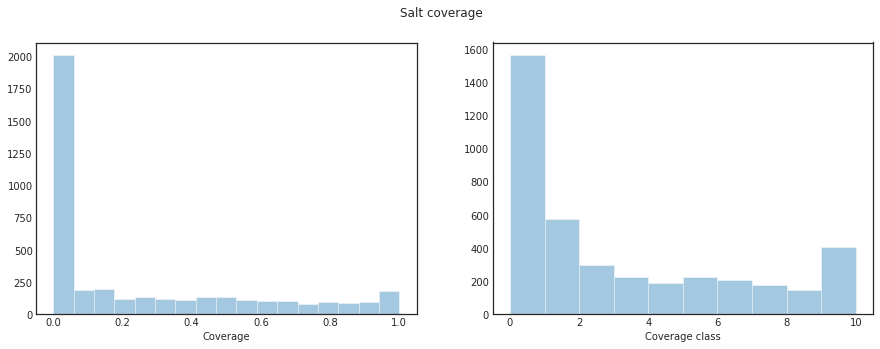

In [15]:
plot_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

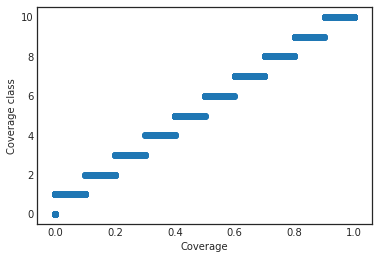

In [16]:
scatter_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


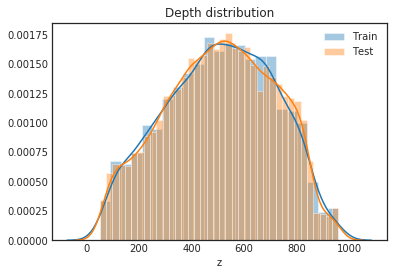

In [17]:
plot_depth_distributions(train_df.z, test_df.z)

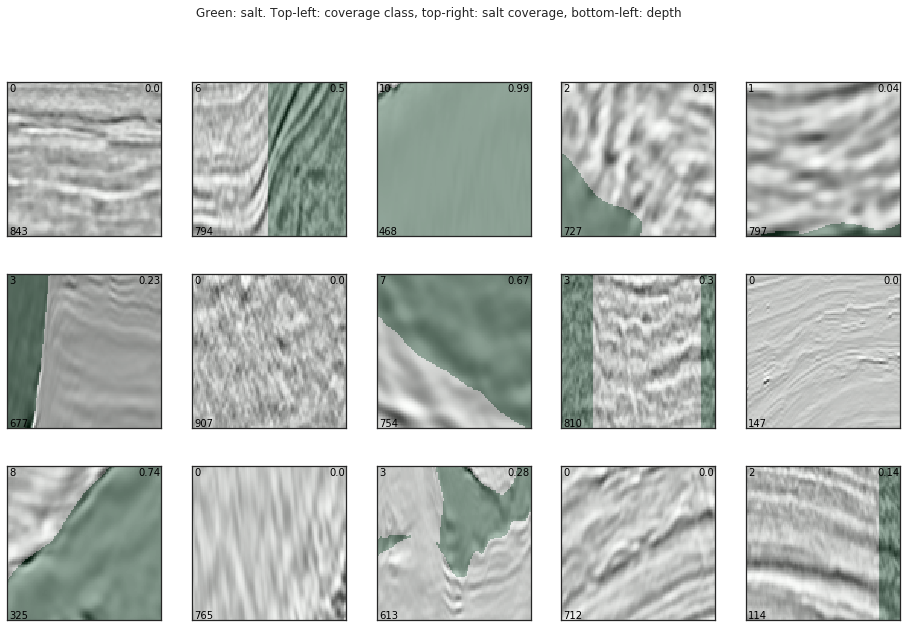

In [18]:
plot_images(train_df, max_images=15, grid_width=5, figsize=(16,10))

In [19]:
upsample_to = upsample(101, img_size_target)

In [20]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample_to).tolist()).reshape(-1, 1, img_size_target, img_size_target), 
    np.array(train_df.masks.map(upsample_to).tolist()).reshape(-1, 1, img_size_target, img_size_target), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.coverage_class, 
    random_state=seed)

In [21]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [22]:
x_train.shape

(6400, 1, 101, 101)

In [23]:
dataset = TGSSaltDataset(x_train, y_data=y_train)
dataset_val = TGSSaltDataset(x_valid, y_data=y_valid)

In [24]:
state = {
        'state_dict': None,
        'optimizer': None,
        'epoch': 0,
        'val_iou': 0,
        'best_val_iou': 0,
        'best_epoch': 0,
}

In [25]:
train_data_loader = data.DataLoader(dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True,
                                    num_workers=num_workers,
                                    pin_memory=True,
                                    drop_last=True)
val_data_loader = data.DataLoader(dataset_val, 
                                   batch_size = batch_size,
                                   shuffle = False, 
                                   num_workers=num_workers,
                                   pin_memory=True,
                                   drop_last=False)

In [26]:
config["optim_config"]["steps_per_epoch"] = len(train_data_loader)

In [28]:
optimizer, scheduler = create_optimizer(model.parameters(), config['optim_config'])

In [28]:
history = defaultdict(list)
loss_fn = torch.nn.BCELoss()

global_counter = it.count()
cumulative_epochs_counter = it.count()
cycle_best_val_iou = {}
for cycle in range(num_cycles): # Cosine annealing with warm restarts
    optimizer, scheduler = create_optimizer(model.parameters(), config['optim_config'])
    for epoch in range(epochs):
        cum_epoch = next(cumulative_epochs_counter)
        train_metrics = train(cum_epoch, 
                              model, 
                              optimizer, 
                              scheduler, 
                              loss_fn, 
                              train_data_loader, 
                              config,
                              summary_writer=summary_writer,
                              global_counter=global_counter)

        val_metrics = test(cum_epoch, 
                           model, 
                           loss_fn, 
                           val_data_loader, 
                           summary_writer=summary_writer)

        state = update_state(state, 
                             cum_epoch, 
                             'val_iou', 
                             np.mean(val_metrics['iou']), 
                             model, 
                             optimizer)
        
        save_checkpoint(state, best_model_filename=f"model_{cycle}_best_state.pth")

        history['epoch'].append(cum_epoch)
        history['train_loss'].append(np.mean(train_metrics['loss']))
        history['val_loss'].append(np.mean(val_metrics['loss']))
        history['train_iou'].append(np.mean(train_metrics['iou']))
        history['val_iou'].append(np.mean(val_metrics['iou']))
    cycle_best_val_iou[cycle]=state['best_val_iou']

INFO:training:Train 0
INFO:training:Epoch: 0,Step: 0,Train: loss 2.433,  IoU 0.077
INFO:training:Epoch: 0,Step: 49,Train: loss 0.632,  IoU 0.148
INFO:training:Elapsed 15.77
INFO:training:Test 0
INFO:training:Epoch: 0,Val: loss 0.619, IoU 0.147 ** 
INFO:training:Elapsed 3.94
INFO:model:val_iou went from 0 to 0.1470982142857143 >:)
INFO:training:Train 1
INFO:training:Epoch: 1,Step: 0,Train: loss 0.421,  IoU 0.234
INFO:training:Epoch: 1,Step: 49,Train: loss 0.417,  IoU 0.325
INFO:training:Elapsed 12.89
INFO:training:Test 1
INFO:training:Epoch: 1,Val: loss 0.576, IoU 0.191 ** 
INFO:training:Elapsed 3.00
INFO:model:val_iou went from 0.1470982142857143 to 0.1910714285714286 >:)
INFO:training:Train 2
INFO:training:Epoch: 2,Step: 0,Train: loss 0.372,  IoU 0.338
INFO:training:Epoch: 2,Step: 49,Train: loss 0.398,  IoU 0.390
INFO:training:Elapsed 11.96
INFO:training:Test 2
INFO:training:Epoch: 2,Val: loss 0.508, IoU 0.315 ** 
INFO:training:Elapsed 2.86
INFO:model:val_iou went from 0.1910714285714

INFO:training:Epoch: 26,Step: 0,Train: loss 0.232,  IoU 0.590
INFO:training:Epoch: 26,Step: 49,Train: loss 0.221,  IoU 0.596
INFO:training:Elapsed 11.55
INFO:training:Test 26
INFO:training:Epoch: 26,Val: loss 0.237, IoU 0.616 ** 
INFO:training:Elapsed 2.49
INFO:training:Train 27
INFO:training:Epoch: 27,Step: 0,Train: loss 0.247,  IoU 0.552
INFO:training:Epoch: 27,Step: 49,Train: loss 0.219,  IoU 0.597
INFO:training:Elapsed 11.63
INFO:training:Test 27
INFO:training:Epoch: 27,Val: loss 0.234, IoU 0.618 ** 
INFO:training:Elapsed 2.52
INFO:training:Train 28
INFO:training:Epoch: 28,Step: 0,Train: loss 0.154,  IoU 0.621
INFO:training:Epoch: 28,Step: 49,Train: loss 0.215,  IoU 0.598
INFO:training:Elapsed 11.41
INFO:training:Test 28
INFO:training:Epoch: 28,Val: loss 0.217, IoU 0.629 ** 
INFO:training:Elapsed 2.56
INFO:model:val_iou went from 0.6188616071428571 to 0.6293526785714286 >:)
INFO:training:Train 29
INFO:training:Epoch: 29,Step: 0,Train: loss 0.205,  IoU 0.622
INFO:training:Epoch: 29,

INFO:training:Elapsed 2.37
INFO:model:val_iou went from 0.6934151785714285 to 0.6946428571428571 >:)
INFO:training:Train 53
INFO:training:Epoch: 53,Step: 0,Train: loss 0.126,  IoU 0.675
INFO:training:Epoch: 53,Step: 49,Train: loss 0.161,  IoU 0.671
INFO:training:Elapsed 11.42
INFO:training:Test 53
INFO:training:Epoch: 53,Val: loss 0.169, IoU 0.702 ** 
INFO:training:Elapsed 2.39
INFO:model:val_iou went from 0.6946428571428571 to 0.7020089285714286 >:)
INFO:training:Train 54
INFO:training:Epoch: 54,Step: 0,Train: loss 0.160,  IoU 0.629
INFO:training:Epoch: 54,Step: 49,Train: loss 0.158,  IoU 0.668
INFO:training:Elapsed 11.53
INFO:training:Test 54
INFO:training:Epoch: 54,Val: loss 0.168, IoU 0.689 ** 
INFO:training:Elapsed 2.37
INFO:training:Train 55
INFO:training:Epoch: 55,Step: 0,Train: loss 0.162,  IoU 0.659
INFO:training:Epoch: 55,Step: 49,Train: loss 0.157,  IoU 0.675
INFO:training:Elapsed 11.40
INFO:training:Test 55
INFO:training:Epoch: 55,Val: loss 0.165, IoU 0.696 ** 
INFO:trainin

INFO:training:Epoch: 81,Val: loss 0.182, IoU 0.680 ** 
INFO:training:Elapsed 2.42
INFO:training:Train 82
INFO:training:Epoch: 82,Step: 0,Train: loss 0.160,  IoU 0.700
INFO:training:Epoch: 82,Step: 49,Train: loss 0.166,  IoU 0.669
INFO:training:Elapsed 11.45
INFO:training:Test 82
INFO:training:Epoch: 82,Val: loss 0.169, IoU 0.700 ** 
INFO:training:Elapsed 2.38
INFO:training:Train 83
INFO:training:Epoch: 83,Step: 0,Train: loss 0.131,  IoU 0.691
INFO:training:Epoch: 83,Step: 49,Train: loss 0.168,  IoU 0.670
INFO:training:Elapsed 11.37
INFO:training:Test 83
INFO:training:Epoch: 83,Val: loss 0.178, IoU 0.685 ** 
INFO:training:Elapsed 2.35
INFO:training:Train 84
INFO:training:Epoch: 84,Step: 0,Train: loss 0.197,  IoU 0.634
INFO:training:Epoch: 84,Step: 49,Train: loss 0.162,  IoU 0.680
INFO:training:Elapsed 11.48
INFO:training:Test 84
INFO:training:Epoch: 84,Val: loss 0.185, IoU 0.674 ** 
INFO:training:Elapsed 2.37
INFO:training:Train 85
INFO:training:Epoch: 85,Step: 0,Train: loss 0.170,  IoU

INFO:training:Epoch: 109,Step: 0,Train: loss 0.140,  IoU 0.709
INFO:training:Epoch: 109,Step: 49,Train: loss 0.116,  IoU 0.726
INFO:training:Elapsed 11.26
INFO:training:Test 109
INFO:training:Epoch: 109,Val: loss 0.144, IoU 0.728 ** 
INFO:training:Elapsed 2.33
INFO:model:val_iou went from 0.7276785714285714 to 0.7281250000000001 >:)
INFO:training:Train 110
INFO:training:Epoch: 110,Step: 0,Train: loss 0.101,  IoU 0.757
INFO:training:Epoch: 110,Step: 49,Train: loss 0.119,  IoU 0.727
INFO:training:Elapsed 11.33
INFO:training:Test 110
INFO:training:Epoch: 110,Val: loss 0.148, IoU 0.715 ** 
INFO:training:Elapsed 2.33
INFO:training:Train 111
INFO:training:Epoch: 111,Step: 0,Train: loss 0.121,  IoU 0.738
INFO:training:Epoch: 111,Step: 49,Train: loss 0.116,  IoU 0.721
INFO:training:Elapsed 11.33
INFO:training:Test 111
INFO:training:Epoch: 111,Val: loss 0.156, IoU 0.720 ** 
INFO:training:Elapsed 2.29
INFO:training:Train 112
INFO:training:Epoch: 112,Step: 0,Train: loss 0.102,  IoU 0.770
INFO:tra

INFO:training:Test 136
INFO:training:Epoch: 136,Val: loss 0.159, IoU 0.734 ** 
INFO:training:Elapsed 2.24
INFO:training:Train 137
INFO:training:Epoch: 137,Step: 0,Train: loss 0.077,  IoU 0.730
INFO:training:Epoch: 137,Step: 49,Train: loss 0.083,  IoU 0.758
INFO:training:Elapsed 11.20
INFO:training:Test 137
INFO:training:Epoch: 137,Val: loss 0.158, IoU 0.731 ** 
INFO:training:Elapsed 2.23
INFO:training:Train 138
INFO:training:Epoch: 138,Step: 0,Train: loss 0.076,  IoU 0.763
INFO:training:Epoch: 138,Step: 49,Train: loss 0.081,  IoU 0.759
INFO:training:Elapsed 11.26
INFO:training:Test 138
INFO:training:Epoch: 138,Val: loss 0.157, IoU 0.738 ** 
INFO:training:Elapsed 2.25
INFO:training:Train 139
INFO:training:Epoch: 139,Step: 0,Train: loss 0.073,  IoU 0.723
INFO:training:Epoch: 139,Step: 49,Train: loss 0.082,  IoU 0.760
INFO:training:Elapsed 11.18
INFO:training:Test 139
INFO:training:Epoch: 139,Val: loss 0.156, IoU 0.732 ** 
INFO:training:Elapsed 2.25
INFO:training:Train 140
INFO:training:E

INFO:model:val_iou went from 0.7439732142857143 to 0.74609375 >:)
INFO:training:Train 174
INFO:training:Epoch: 174,Step: 0,Train: loss 0.112,  IoU 0.728
INFO:training:Epoch: 174,Step: 49,Train: loss 0.080,  IoU 0.761
INFO:training:Elapsed 11.17
INFO:training:Test 174
INFO:training:Epoch: 174,Val: loss 0.182, IoU 0.711 ** 
INFO:training:Elapsed 2.23
INFO:training:Train 175
INFO:training:Epoch: 175,Step: 0,Train: loss 0.071,  IoU 0.748
INFO:training:Epoch: 175,Step: 49,Train: loss 0.075,  IoU 0.772
INFO:training:Elapsed 11.27
INFO:training:Test 175
INFO:training:Epoch: 175,Val: loss 0.178, IoU 0.739 ** 
INFO:training:Elapsed 2.17
INFO:training:Train 176
INFO:training:Epoch: 176,Step: 0,Train: loss 0.068,  IoU 0.748
INFO:training:Epoch: 176,Step: 49,Train: loss 0.080,  IoU 0.766
INFO:training:Elapsed 11.19
INFO:training:Test 176
INFO:training:Epoch: 176,Val: loss 0.171, IoU 0.728 ** 
INFO:training:Elapsed 2.21
INFO:training:Train 177
INFO:training:Epoch: 177,Step: 0,Train: loss 0.054,  Io

INFO:training:Epoch: 202,Step: 0,Train: loss 0.041,  IoU 0.767
INFO:training:Epoch: 202,Step: 49,Train: loss 0.050,  IoU 0.806
INFO:training:Elapsed 11.13
INFO:training:Test 202
INFO:training:Epoch: 202,Val: loss 0.176, IoU 0.751 ** 
INFO:training:Elapsed 2.15
INFO:training:Train 203
INFO:training:Epoch: 203,Step: 0,Train: loss 0.057,  IoU 0.816
INFO:training:Epoch: 203,Step: 49,Train: loss 0.050,  IoU 0.806
INFO:training:Elapsed 11.06
INFO:training:Test 203
INFO:training:Epoch: 203,Val: loss 0.179, IoU 0.751 ** 
INFO:training:Elapsed 2.17
INFO:training:Train 204
INFO:training:Epoch: 204,Step: 0,Train: loss 0.051,  IoU 0.807
INFO:training:Epoch: 204,Step: 49,Train: loss 0.050,  IoU 0.801
INFO:training:Elapsed 11.02
INFO:training:Test 204
INFO:training:Epoch: 204,Val: loss 0.177, IoU 0.750 ** 
INFO:training:Elapsed 2.15
INFO:training:Train 205
INFO:training:Epoch: 205,Step: 0,Train: loss 0.049,  IoU 0.873
INFO:training:Epoch: 205,Step: 49,Train: loss 0.054,  IoU 0.805
INFO:training:Elap

INFO:training:Elapsed 2.20
INFO:training:Train 231
INFO:training:Epoch: 231,Step: 0,Train: loss 0.117,  IoU 0.755
INFO:training:Epoch: 231,Step: 49,Train: loss 0.083,  IoU 0.762
INFO:training:Elapsed 11.15
INFO:training:Test 231
INFO:training:Epoch: 231,Val: loss 0.168, IoU 0.732 ** 
INFO:training:Elapsed 2.22
INFO:training:Train 232
INFO:training:Epoch: 232,Step: 0,Train: loss 0.081,  IoU 0.745
INFO:training:Epoch: 232,Step: 49,Train: loss 0.081,  IoU 0.765
INFO:training:Elapsed 11.07
INFO:training:Test 232
INFO:training:Epoch: 232,Val: loss 0.174, IoU 0.726 ** 
INFO:training:Elapsed 2.22
INFO:training:Train 233
INFO:training:Epoch: 233,Step: 0,Train: loss 0.107,  IoU 0.717
INFO:training:Epoch: 233,Step: 49,Train: loss 0.074,  IoU 0.777
INFO:training:Elapsed 11.27
INFO:training:Test 233
INFO:training:Epoch: 233,Val: loss 0.193, IoU 0.723 ** 
INFO:training:Elapsed 2.20
INFO:training:Train 234
INFO:training:Epoch: 234,Step: 0,Train: loss 0.066,  IoU 0.784
INFO:training:Epoch: 234,Step: 

INFO:training:Epoch: 259,Step: 49,Train: loss 0.041,  IoU 0.825
INFO:training:Elapsed 11.12
INFO:training:Test 259
INFO:training:Epoch: 259,Val: loss 0.207, IoU 0.742 ** 
INFO:training:Elapsed 2.15
INFO:training:Train 260
INFO:training:Epoch: 260,Step: 0,Train: loss 0.036,  IoU 0.821
INFO:training:Epoch: 260,Step: 49,Train: loss 0.041,  IoU 0.821
INFO:training:Elapsed 11.05
INFO:training:Test 260
INFO:training:Epoch: 260,Val: loss 0.189, IoU 0.748 ** 
INFO:training:Elapsed 2.11
INFO:training:Train 261
INFO:training:Epoch: 261,Step: 0,Train: loss 0.041,  IoU 0.848
INFO:training:Epoch: 261,Step: 49,Train: loss 0.040,  IoU 0.825
INFO:training:Elapsed 11.09
INFO:training:Test 261
INFO:training:Epoch: 261,Val: loss 0.193, IoU 0.743 ** 
INFO:training:Elapsed 2.10
INFO:training:Train 262
INFO:training:Epoch: 262,Step: 0,Train: loss 0.048,  IoU 0.799
INFO:training:Epoch: 262,Step: 49,Train: loss 0.039,  IoU 0.824
INFO:training:Elapsed 11.04
INFO:training:Test 262
INFO:training:Epoch: 262,Val: 

INFO:training:Epoch: 288,Step: 0,Train: loss 0.073,  IoU 0.766
INFO:training:Epoch: 288,Step: 49,Train: loss 0.074,  IoU 0.774
INFO:training:Elapsed 11.22
INFO:training:Test 288
INFO:training:Epoch: 288,Val: loss 0.191, IoU 0.725 ** 
INFO:training:Elapsed 2.22
INFO:training:Train 289
INFO:training:Epoch: 289,Step: 0,Train: loss 0.063,  IoU 0.780
INFO:training:Epoch: 289,Step: 49,Train: loss 0.073,  IoU 0.780
INFO:training:Elapsed 11.14
INFO:training:Test 289
INFO:training:Epoch: 289,Val: loss 0.168, IoU 0.743 ** 
INFO:training:Elapsed 2.14
INFO:training:Train 290
INFO:training:Epoch: 290,Step: 0,Train: loss 0.083,  IoU 0.772
INFO:training:Epoch: 290,Step: 49,Train: loss 0.075,  IoU 0.776
INFO:training:Elapsed 11.04
INFO:training:Test 290
INFO:training:Epoch: 290,Val: loss 0.167, IoU 0.707 ** 
INFO:training:Elapsed 2.20
INFO:training:Train 291
INFO:training:Epoch: 291,Step: 0,Train: loss 0.073,  IoU 0.734
INFO:training:Epoch: 291,Step: 49,Train: loss 0.068,  IoU 0.784
INFO:training:Elap

INFO:training:Elapsed 2.09
INFO:training:Train 317
INFO:training:Epoch: 317,Step: 0,Train: loss 0.032,  IoU 0.841
INFO:training:Epoch: 317,Step: 49,Train: loss 0.038,  IoU 0.831
INFO:training:Elapsed 11.17
INFO:training:Test 317
INFO:training:Epoch: 317,Val: loss 0.226, IoU 0.749 ** 
INFO:training:Elapsed 2.10
INFO:training:Train 318
INFO:training:Epoch: 318,Step: 0,Train: loss 0.034,  IoU 0.809
INFO:training:Epoch: 318,Step: 49,Train: loss 0.036,  IoU 0.835
INFO:training:Elapsed 11.09
INFO:training:Test 318
INFO:training:Epoch: 318,Val: loss 0.228, IoU 0.722 ** 
INFO:training:Elapsed 2.11
INFO:training:Train 319
INFO:training:Epoch: 319,Step: 0,Train: loss 0.038,  IoU 0.858
INFO:training:Epoch: 319,Step: 49,Train: loss 0.035,  IoU 0.835
INFO:training:Elapsed 11.05
INFO:training:Test 319
INFO:training:Epoch: 319,Val: loss 0.235, IoU 0.745 ** 
INFO:training:Elapsed 2.05
INFO:training:Train 320
INFO:training:Epoch: 320,Step: 0,Train: loss 0.028,  IoU 0.884
INFO:training:Epoch: 320,Step: 

INFO:training:Epoch: 345,Val: loss 0.236, IoU 0.748 ** 
INFO:training:Elapsed 2.10
INFO:training:Train 346
INFO:training:Epoch: 346,Step: 0,Train: loss 0.028,  IoU 0.857
INFO:training:Epoch: 346,Step: 49,Train: loss 0.030,  IoU 0.850
INFO:training:Elapsed 11.09
INFO:training:Test 346
INFO:training:Epoch: 346,Val: loss 0.234, IoU 0.745 ** 
INFO:training:Elapsed 2.12
INFO:training:Train 347
INFO:training:Epoch: 347,Step: 0,Train: loss 0.025,  IoU 0.893
INFO:training:Epoch: 347,Step: 49,Train: loss 0.029,  IoU 0.849
INFO:training:Elapsed 10.97
INFO:training:Test 347
INFO:training:Epoch: 347,Val: loss 0.235, IoU 0.750 ** 
INFO:training:Elapsed 2.08
INFO:training:Train 348
INFO:training:Epoch: 348,Step: 0,Train: loss 0.026,  IoU 0.841
INFO:training:Epoch: 348,Step: 49,Train: loss 0.029,  IoU 0.851
INFO:training:Elapsed 11.14
INFO:training:Test 348
INFO:training:Epoch: 348,Val: loss 0.240, IoU 0.747 ** 
INFO:training:Elapsed 2.08
INFO:training:Train 349
INFO:training:Epoch: 349,Step: 0,Train

INFO:training:Elapsed 10.99
INFO:training:Test 374
INFO:training:Epoch: 374,Val: loss 0.226, IoU 0.738 ** 
INFO:training:Elapsed 2.22
INFO:training:Train 375
INFO:training:Epoch: 375,Step: 0,Train: loss 0.033,  IoU 0.816
INFO:training:Epoch: 375,Step: 49,Train: loss 0.047,  IoU 0.815
INFO:training:Elapsed 11.01
INFO:training:Test 375
INFO:training:Epoch: 375,Val: loss 0.199, IoU 0.745 ** 
INFO:training:Elapsed 2.15
INFO:training:Train 376
INFO:training:Epoch: 376,Step: 0,Train: loss 0.047,  IoU 0.800
INFO:training:Epoch: 376,Step: 49,Train: loss 0.047,  IoU 0.812
INFO:training:Elapsed 11.12
INFO:training:Test 376
INFO:training:Epoch: 376,Val: loss 0.193, IoU 0.736 ** 
INFO:training:Elapsed 2.14
INFO:training:Train 377
INFO:training:Epoch: 377,Step: 0,Train: loss 0.051,  IoU 0.784
INFO:training:Epoch: 377,Step: 49,Train: loss 0.041,  IoU 0.821
INFO:training:Elapsed 11.04
INFO:training:Test 377
INFO:training:Epoch: 377,Val: loss 0.202, IoU 0.755 ** 
INFO:training:Elapsed 2.09
INFO:traini

INFO:training:Epoch: 403,Step: 0,Train: loss 0.025,  IoU 0.866
INFO:training:Epoch: 403,Step: 49,Train: loss 0.027,  IoU 0.864
INFO:training:Elapsed 11.09
INFO:training:Test 403
INFO:training:Epoch: 403,Val: loss 0.217, IoU 0.754 ** 
INFO:training:Elapsed 2.08
INFO:training:Train 404
INFO:training:Epoch: 404,Step: 0,Train: loss 0.025,  IoU 0.880
INFO:training:Epoch: 404,Step: 49,Train: loss 0.026,  IoU 0.861
INFO:training:Elapsed 11.10
INFO:training:Test 404
INFO:training:Epoch: 404,Val: loss 0.216, IoU 0.756 ** 
INFO:training:Elapsed 2.12
INFO:training:Train 405
INFO:training:Epoch: 405,Step: 0,Train: loss 0.024,  IoU 0.816
INFO:training:Epoch: 405,Step: 49,Train: loss 0.026,  IoU 0.863
INFO:training:Elapsed 10.98
INFO:training:Test 405
INFO:training:Epoch: 405,Val: loss 0.221, IoU 0.758 ** 
INFO:training:Elapsed 2.11
INFO:training:Train 406
INFO:training:Epoch: 406,Step: 0,Train: loss 0.025,  IoU 0.898
INFO:training:Epoch: 406,Step: 49,Train: loss 0.026,  IoU 0.865
INFO:training:Elap

In [29]:
sorted_by_val_iou = sorted(cycle_best_val_iou.items(), key=itemgetter(1), reverse=True)
best_cycle, best_iou = sorted_by_val_iou[0]
logger.info(f"Best model cycle {best_cycle}: Validation IoU {best_iou}")
logger.info("Saving to model_best_state.pth")
shutil.copy(os.path.join(model_path(), f"model_{best_cycle}_best_state.pth"), 
            os.path.join(model_path(), f"model_best_state.pth"))

INFO:__main__:Best model cycle 5: Validation IoU 0.7584821428571429
INFO:__main__:Saving to model_best_state.pth


'/mnt/models/pytorch_unet_resnetlike/model_best_state.pth'

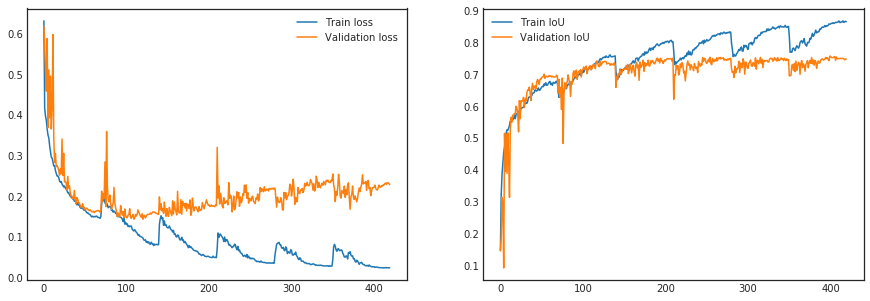

In [30]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history['epoch'], history['train_loss'], label="Train loss")
ax_loss.plot(history['epoch'], history['val_loss'], label="Validation loss")
ax_loss.legend()
ax_iou.plot(history['epoch'], history['train_iou'], label="Train IoU")
ax_iou.plot(history['epoch'], history['val_iou'], label="Validation IoU")
ax_iou.legend()

In [29]:
filename = os.path.join(model_path(), 'model_best_state.pth')
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [30]:
def predict_tta(model, image): # predict both orginal and reflect x
    with torch.no_grad():
        image_reflect = np.flip(image.numpy(), axis=3).copy()
        with torch.cuda.device(0):
            image_gpu = image.type(torch.float).cuda()
            image_reflect_gpu = torch.as_tensor(image_reflect).type(torch.float).cuda()
        
        outputs = model(image_gpu)
        outputs_reflect = model(image_reflect_gpu)
        return (outputs.cpu().numpy() + np.flip(outputs_reflect.cpu().numpy(), axis=3))/2

In [31]:
model.eval()
predictions=[predict_tta(model, image) for image, _ in tqdm(val_data_loader)]

100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


In [32]:
preds_valid = np.concatenate(predictions, axis=0).squeeze()

In [33]:
downsample_to = downsample(128, 101)

In [34]:
preds_valid=np.array(list(map(downsample_to, preds_valid)))

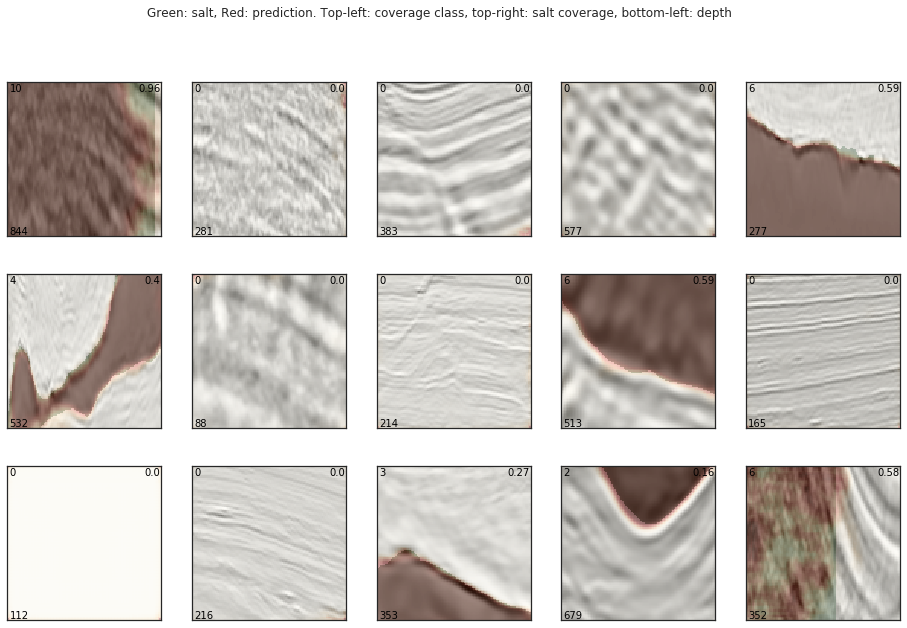

In [35]:
plot_predictions(train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [36]:
## Scoring for last model, choose threshold using validation data 
thresholds = np.linspace(0.3, 0.7, 31)
y_valid_down = np.array(list(map(downsample_to, y_valid.squeeze())))

ious = list(map(lambda th: iou_metric_batch(y_valid_down , np.int32(preds_valid > th)), 
                tqdm(thresholds)))

100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


In [37]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

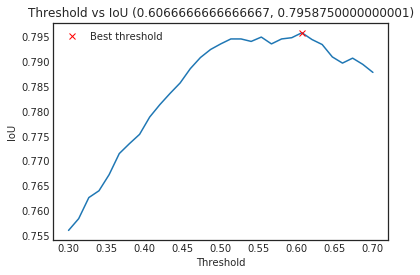

In [38]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [39]:
preds_thresh_iter = map(lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32), preds_valid)
preds_thresh = np.array(list(map(downsample_to, preds_thresh_iter)))

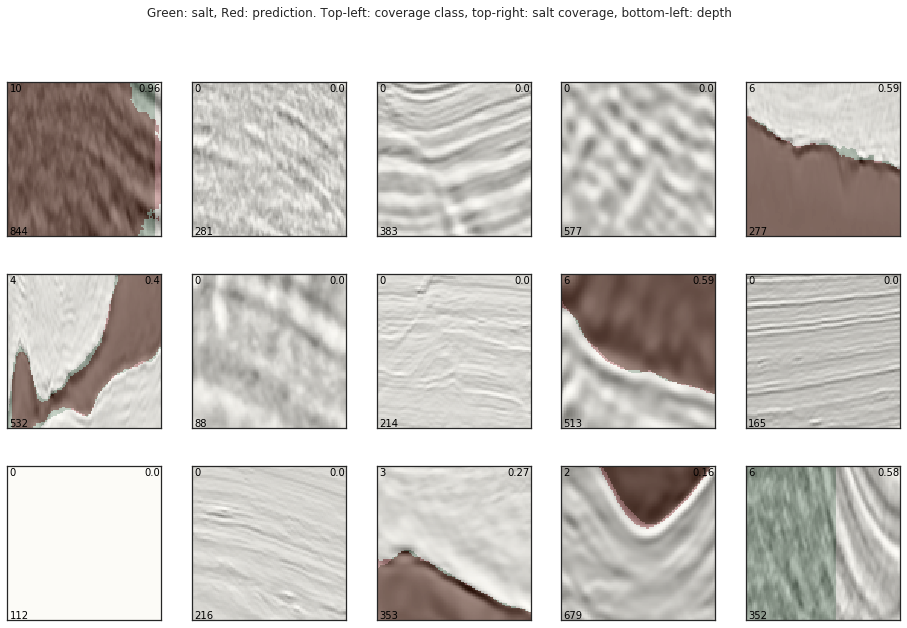

In [40]:
plot_predictions(train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [41]:
# We replace the final sigmoid layer with an identity function
model.module.final_activation = Sequential() # For model wrapped in data parallel we need the module qualifier
# The output now will be centered around zero and unsquashed so we also need to modify the iou metric
metrics = (('iou', my_iou_metric(threshold=0)),) #

In [42]:
state = {
        'state_dict': None,
        'optimizer': None,
        'epoch': 0,
        'val_iou': 0,
        'best_val_iou': 0,
        'best_epoch': 0,
}

In [43]:
optim_config= {
    "optimizer": "sgd",
    "base_lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "nesterov": True,
    "epochs": epochs,
    "scheduler": "cosine",
    "lr_min": 0,
    "steps_per_epoch":len(train_data_loader)
}

In [44]:
lovasz_history = defaultdict(list)
loss_fn = lovasz_hinge

global_counter = it.count()
cumulative_epochs_counter = it.count()
cycle_best_val_iou = {}
for cycle in range(num_cycles): # Cosine annealing with warm restarts
    optimizer, scheduler = create_optimizer(model.parameters(), optim_config)
    for epoch in range(epochs):
        cum_epoch = next(cumulative_epochs_counter)
        train_metrics = train(cum_epoch, 
                              model, 
                              optimizer, 
                              scheduler, 
                              loss_fn, 
                              train_data_loader, 
                              config,
                              summary_writer=summary_writer,
                              global_counter=global_counter,
                              metrics_funcs=metrics)

        val_metrics = test(cum_epoch, 
                           model, 
                           loss_fn, 
                           val_data_loader, 
                           summary_writer=summary_writer,
                           metrics_funcs=metrics)

        state = update_state(state, 
                             cum_epoch, 
                             'val_iou', 
                             np.mean(val_metrics['iou']), 
                             model, 
                             optimizer)
        
        save_checkpoint(state, best_model_filename=f"model_lovasz_{cycle}_best_state.pth")

        lovasz_history['epoch'].append(cum_epoch)
        lovasz_history['train_loss'].append(np.mean(train_metrics['loss']))
        lovasz_history['val_loss'].append(np.mean(val_metrics['loss']))
        lovasz_history['train_iou'].append(np.mean(train_metrics['iou']))
        lovasz_history['val_iou'].append(np.mean(val_metrics['iou']))
    cycle_best_val_iou[cycle]=state['best_val_iou']

INFO:training:Train 0
INFO:training:Epoch: 0,Step: 0,Train: loss 0.420,  IoU 0.861
INFO:training:Epoch: 0,Step: 49,Train: loss 0.373,  IoU 0.841
INFO:training:Elapsed 17.49
INFO:training:Test 0
INFO:training:Epoch: 0,Val: loss 0.730, IoU 0.753 ** 
INFO:training:Elapsed 1.27
INFO:model:val_iou went from 0 to 0.7530133928571429 >:)
INFO:training:Train 1
INFO:training:Epoch: 1,Step: 0,Train: loss 0.234,  IoU 0.857
INFO:training:Epoch: 1,Step: 49,Train: loss 0.299,  IoU 0.850
INFO:training:Elapsed 16.23
INFO:training:Test 1
INFO:training:Epoch: 1,Val: loss 0.609, IoU 0.763 ** 
INFO:training:Elapsed 1.26
INFO:model:val_iou went from 0.7530133928571429 to 0.7630580357142857 >:)
INFO:training:Train 2
INFO:training:Epoch: 2,Step: 0,Train: loss 0.301,  IoU 0.833
INFO:training:Epoch: 2,Step: 49,Train: loss 0.279,  IoU 0.854
INFO:training:Elapsed 16.17
INFO:training:Test 2
INFO:training:Epoch: 2,Val: loss 0.609, IoU 0.759 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 3
INFO:training:Epoch: 3

INFO:training:Epoch: 28,Step: 49,Train: loss 0.203,  IoU 0.875
INFO:training:Elapsed 16.18
INFO:training:Test 28
INFO:training:Epoch: 28,Val: loss 0.449, IoU 0.766 ** 
INFO:training:Elapsed 1.25
INFO:training:Train 29
INFO:training:Epoch: 29,Step: 0,Train: loss 0.222,  IoU 0.870
INFO:training:Epoch: 29,Step: 49,Train: loss 0.193,  IoU 0.879
INFO:training:Elapsed 16.20
INFO:training:Test 29
INFO:training:Epoch: 29,Val: loss 0.453, IoU 0.766 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 30
INFO:training:Epoch: 30,Step: 0,Train: loss 0.225,  IoU 0.862
INFO:training:Epoch: 30,Step: 49,Train: loss 0.197,  IoU 0.879
INFO:training:Elapsed 16.21
INFO:training:Test 30
INFO:training:Epoch: 30,Val: loss 0.453, IoU 0.771 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 31
INFO:training:Epoch: 31,Step: 0,Train: loss 0.217,  IoU 0.868
INFO:training:Epoch: 31,Step: 49,Train: loss 0.190,  IoU 0.882
INFO:training:Elapsed 16.30
INFO:training:Test 31
INFO:training:Epoch: 31,Val: loss 0.454, IoU 0.

INFO:training:Test 57
INFO:training:Epoch: 57,Val: loss 0.466, IoU 0.762 ** 
INFO:training:Elapsed 1.27
INFO:training:Train 58
INFO:training:Epoch: 58,Step: 0,Train: loss 0.134,  IoU 0.907
INFO:training:Epoch: 58,Step: 49,Train: loss 0.163,  IoU 0.896
INFO:training:Elapsed 16.26
INFO:training:Test 58
INFO:training:Epoch: 58,Val: loss 0.468, IoU 0.761 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 59
INFO:training:Epoch: 59,Step: 0,Train: loss 0.180,  IoU 0.894
INFO:training:Epoch: 59,Step: 49,Train: loss 0.163,  IoU 0.896
INFO:training:Elapsed 16.21
INFO:training:Test 59
INFO:training:Epoch: 59,Val: loss 0.468, IoU 0.761 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 60
INFO:training:Epoch: 60,Step: 0,Train: loss 0.177,  IoU 0.898
INFO:training:Epoch: 60,Step: 49,Train: loss 0.161,  IoU 0.896
INFO:training:Elapsed 16.14
INFO:training:Test 60
INFO:training:Epoch: 60,Val: loss 0.459, IoU 0.763 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 61
INFO:training:Epoch: 61,Step: 0,T

INFO:training:Elapsed 1.24
INFO:training:Train 87
INFO:training:Epoch: 87,Step: 0,Train: loss 0.167,  IoU 0.893
INFO:training:Epoch: 87,Step: 49,Train: loss 0.203,  IoU 0.872
INFO:training:Elapsed 16.07
INFO:training:Test 87
INFO:training:Epoch: 87,Val: loss 0.437, IoU 0.760 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 88
INFO:training:Epoch: 88,Step: 0,Train: loss 0.195,  IoU 0.881
INFO:training:Epoch: 88,Step: 49,Train: loss 0.213,  IoU 0.865
INFO:training:Elapsed 16.06
INFO:training:Test 88
INFO:training:Epoch: 88,Val: loss 0.445, IoU 0.764 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 89
INFO:training:Epoch: 89,Step: 0,Train: loss 0.212,  IoU 0.851
INFO:training:Epoch: 89,Step: 49,Train: loss 0.214,  IoU 0.864
INFO:training:Elapsed 16.16
INFO:training:Test 89
INFO:training:Epoch: 89,Val: loss 0.427, IoU 0.767 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 90
INFO:training:Epoch: 90,Step: 0,Train: loss 0.141,  IoU 0.915
INFO:training:Epoch: 90,Step: 49,Train: loss 0.2

INFO:training:Test 115
INFO:training:Epoch: 115,Val: loss 0.416, IoU 0.762 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 116
INFO:training:Epoch: 116,Step: 0,Train: loss 0.170,  IoU 0.887
INFO:training:Epoch: 116,Step: 49,Train: loss 0.159,  IoU 0.896
INFO:training:Elapsed 16.08
INFO:training:Test 116
INFO:training:Epoch: 116,Val: loss 0.422, IoU 0.764 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 117
INFO:training:Epoch: 117,Step: 0,Train: loss 0.168,  IoU 0.894
INFO:training:Epoch: 117,Step: 49,Train: loss 0.159,  IoU 0.897
INFO:training:Elapsed 16.09
INFO:training:Test 117
INFO:training:Epoch: 117,Val: loss 0.418, IoU 0.766 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 118
INFO:training:Epoch: 118,Step: 0,Train: loss 0.188,  IoU 0.874
INFO:training:Epoch: 118,Step: 49,Train: loss 0.157,  IoU 0.898
INFO:training:Elapsed 15.98
INFO:training:Test 118
INFO:training:Epoch: 118,Val: loss 0.403, IoU 0.775 ** 
INFO:training:Elapsed 1.25
INFO:training:Train 119
INFO:training:E

INFO:training:Elapsed 16.11
INFO:training:Test 144
INFO:training:Epoch: 144,Val: loss 0.482, IoU 0.735 ** 
INFO:training:Elapsed 1.25
INFO:training:Train 145
INFO:training:Epoch: 145,Step: 0,Train: loss 0.264,  IoU 0.835
INFO:training:Epoch: 145,Step: 49,Train: loss 0.258,  IoU 0.836
INFO:training:Elapsed 16.05
INFO:training:Test 145
INFO:training:Epoch: 145,Val: loss 0.427, IoU 0.756 ** 
INFO:training:Elapsed 1.25
INFO:training:Train 146
INFO:training:Epoch: 146,Step: 0,Train: loss 0.220,  IoU 0.853
INFO:training:Epoch: 146,Step: 49,Train: loss 0.223,  IoU 0.857
INFO:training:Elapsed 16.10
INFO:training:Test 146
INFO:training:Epoch: 146,Val: loss 0.433, IoU 0.763 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 147
INFO:training:Epoch: 147,Step: 0,Train: loss 0.234,  IoU 0.848
INFO:training:Epoch: 147,Step: 49,Train: loss 0.208,  IoU 0.866
INFO:training:Elapsed 16.12
INFO:training:Test 147
INFO:training:Epoch: 147,Val: loss 0.444, IoU 0.759 ** 
INFO:training:Elapsed 1.26
INFO:traini

INFO:training:Epoch: 173,Step: 49,Train: loss 0.183,  IoU 0.882
INFO:training:Elapsed 16.01
INFO:training:Test 173
INFO:training:Epoch: 173,Val: loss 0.391, IoU 0.772 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 174
INFO:training:Epoch: 174,Step: 0,Train: loss 0.188,  IoU 0.869
INFO:training:Epoch: 174,Step: 49,Train: loss 0.175,  IoU 0.886
INFO:training:Elapsed 15.94
INFO:training:Test 174
INFO:training:Epoch: 174,Val: loss 0.406, IoU 0.768 ** 
INFO:training:Elapsed 1.23
INFO:training:Train 175
INFO:training:Epoch: 175,Step: 0,Train: loss 0.308,  IoU 0.802
INFO:training:Epoch: 175,Step: 49,Train: loss 0.185,  IoU 0.879
INFO:training:Elapsed 15.97
INFO:training:Test 175
INFO:training:Epoch: 175,Val: loss 0.422, IoU 0.759 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 176
INFO:training:Epoch: 176,Step: 0,Train: loss 0.187,  IoU 0.877
INFO:training:Epoch: 176,Step: 49,Train: loss 0.174,  IoU 0.886
INFO:training:Elapsed 15.97
INFO:training:Test 176
INFO:training:Epoch: 176,Val: 

INFO:training:Epoch: 201,Step: 0,Train: loss 0.119,  IoU 0.916
INFO:training:Epoch: 201,Step: 49,Train: loss 0.145,  IoU 0.905
INFO:training:Elapsed 15.93
INFO:training:Test 201
INFO:training:Epoch: 201,Val: loss 0.371, IoU 0.782 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 202
INFO:training:Epoch: 202,Step: 0,Train: loss 0.163,  IoU 0.899
INFO:training:Epoch: 202,Step: 49,Train: loss 0.143,  IoU 0.906
INFO:training:Elapsed 15.87
INFO:training:Test 202
INFO:training:Epoch: 202,Val: loss 0.369, IoU 0.782 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 203
INFO:training:Epoch: 203,Step: 0,Train: loss 0.123,  IoU 0.918
INFO:training:Epoch: 203,Step: 49,Train: loss 0.146,  IoU 0.905
INFO:training:Elapsed 15.96
INFO:training:Test 203
INFO:training:Epoch: 203,Val: loss 0.372, IoU 0.782 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 204
INFO:training:Epoch: 204,Step: 0,Train: loss 0.125,  IoU 0.916
INFO:training:Epoch: 204,Step: 49,Train: loss 0.144,  IoU 0.905
INFO:training:Elap

INFO:training:Elapsed 1.23
INFO:training:Train 230
INFO:training:Epoch: 230,Step: 0,Train: loss 0.172,  IoU 0.896
INFO:training:Epoch: 230,Step: 49,Train: loss 0.263,  IoU 0.835
INFO:training:Elapsed 15.96
INFO:training:Test 230
INFO:training:Epoch: 230,Val: loss 0.408, IoU 0.757 ** 
INFO:training:Elapsed 1.23
INFO:training:Train 231
INFO:training:Epoch: 231,Step: 0,Train: loss 0.230,  IoU 0.845
INFO:training:Epoch: 231,Step: 49,Train: loss 0.243,  IoU 0.844
INFO:training:Elapsed 16.00
INFO:training:Test 231
INFO:training:Epoch: 231,Val: loss 0.410, IoU 0.758 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 232
INFO:training:Epoch: 232,Step: 0,Train: loss 0.116,  IoU 0.923
INFO:training:Epoch: 232,Step: 49,Train: loss 0.276,  IoU 0.823
INFO:training:Elapsed 15.94
INFO:training:Test 232
INFO:training:Epoch: 232,Val: loss 0.463, IoU 0.733 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 233
INFO:training:Epoch: 233,Step: 0,Train: loss 0.287,  IoU 0.825
INFO:training:Epoch: 233,Step: 

INFO:training:Epoch: 258,Val: loss 0.386, IoU 0.770 ** 
INFO:training:Elapsed 1.23
INFO:training:Train 259
INFO:training:Epoch: 259,Step: 0,Train: loss 0.168,  IoU 0.875
INFO:training:Epoch: 259,Step: 49,Train: loss 0.160,  IoU 0.895
INFO:training:Elapsed 15.97
INFO:training:Test 259
INFO:training:Epoch: 259,Val: loss 0.380, IoU 0.775 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 260
INFO:training:Epoch: 260,Step: 0,Train: loss 0.152,  IoU 0.898
INFO:training:Epoch: 260,Step: 49,Train: loss 0.157,  IoU 0.897
INFO:training:Elapsed 15.93
INFO:training:Test 260
INFO:training:Epoch: 260,Val: loss 0.412, IoU 0.761 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 261
INFO:training:Epoch: 261,Step: 0,Train: loss 0.199,  IoU 0.865
INFO:training:Epoch: 261,Step: 49,Train: loss 0.159,  IoU 0.895
INFO:training:Elapsed 16.00
INFO:training:Test 261
INFO:training:Epoch: 261,Val: loss 0.384, IoU 0.774 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 262
INFO:training:Epoch: 262,Step: 0,Train

KeyboardInterrupt: 

In [45]:
sorted_by_val_iou = sorted(cycle_best_val_iou.items(), key=itemgetter(1), reverse=True)
best_cycle, best_iou = sorted_by_val_iou[0]
logger.info(f"Best model cycle {best_cycle}: Validation IoU {best_iou}")
logger.info("Saving to model_lovasz_state.pth")
shutil.copy(os.path.join(model_path(), f"model_lovasz_{best_cycle}_best_state.pth"), 
            os.path.join(model_path(), f"model_lovasz__best_state.pth"))

INFO:__main__:Best model cycle 2: Validation IoU 0.7868303571428571
INFO:__main__:Saving to model_lovasz_state.pth


'/mnt/models/pytorch_unet_resnetlike/model_lovasz__best_state.pth'

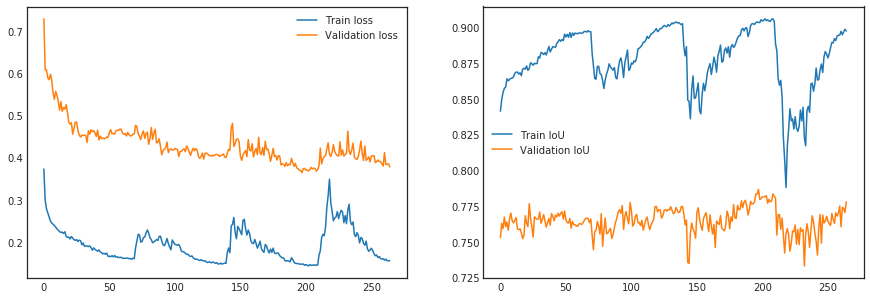

In [46]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(lovasz_history['epoch'], lovasz_history['train_loss'], label="Train loss")
ax_loss.plot(lovasz_history['epoch'], lovasz_history['val_loss'], label="Validation loss")
ax_loss.legend()
ax_iou.plot(lovasz_history['epoch'], lovasz_history['train_iou'], label="Train IoU")
ax_iou.plot(lovasz_history['epoch'], lovasz_history['val_iou'], label="Validation IoU")
ax_iou.legend()

In [64]:
filename = os.path.join(model_path(), 'model_lovasz__best_state.pth')
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint['state_dict'])

100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


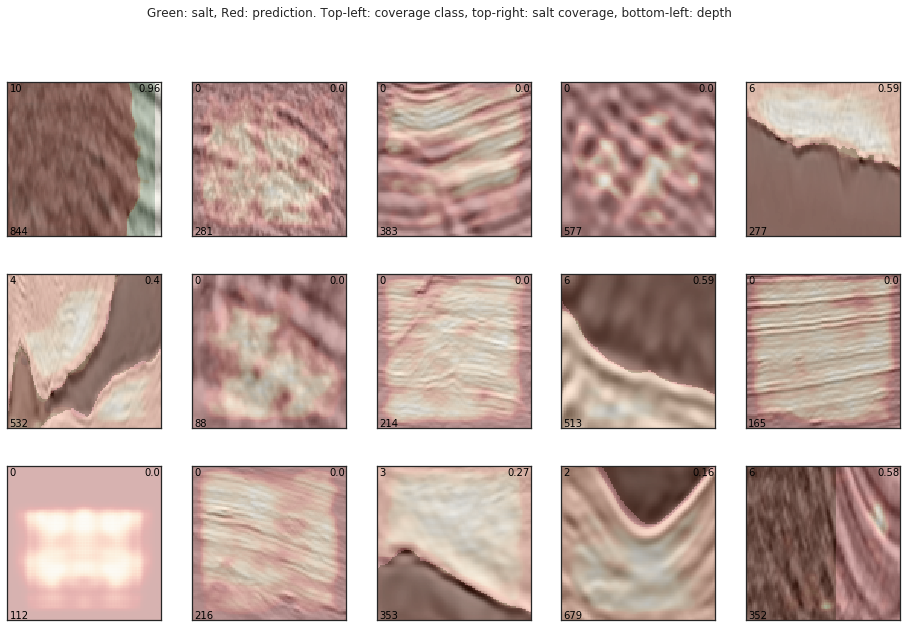

In [65]:
model.eval()
predictions=[predict_tta(model, image) for image, _ in tqdm(val_data_loader)]

preds_valid = np.concatenate(predictions, axis=0).squeeze()
downsample_to = downsample(128, 101)
preds_valid=np.array(list(map(downsample_to, preds_valid)))
plot_predictions(train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [66]:
## Scoring for last model, choose threshold using validation data 
thresholds = np.linspace(0.3, 0.7, 31)
y_valid_down = np.array(list(map(downsample_to, y_valid.squeeze())))
thresholds = np.log(thresholds/(1-thresholds)) 

ious = list(map(lambda th: iou_metric_batch(y_valid_down , np.int32(preds_valid > th)), 
                tqdm(thresholds)))

threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Text(0.5, 1.0, 'Threshold vs IoU (0.2141479884056315, 0.8075)')

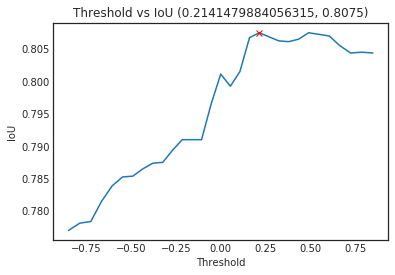

In [67]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))

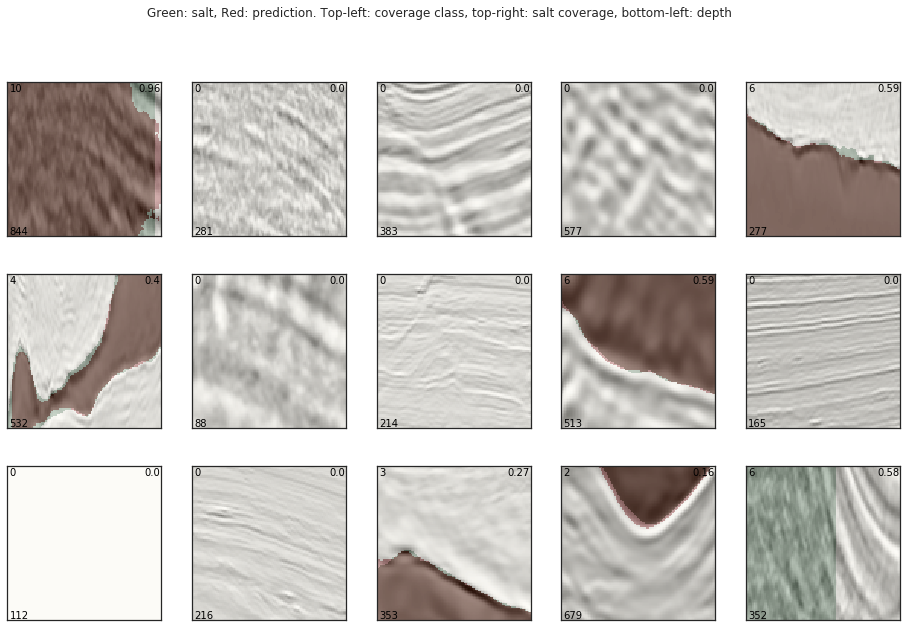

In [68]:
preds_thresh_iter = map(lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32), preds_valid)

plot_predictions(train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16,10))
preds_thresh = np.array(list(map(downsample_to, preds_thresh_iter)))
plt.legend()

In [69]:
x_test = load_images_as_arrays(test_df.index, test_images_path())
x_test = list(map(upsample_to, x_test))
x_test = np.array(x_test).reshape(-1, 1, img_size_target, img_size_target)

100%|██████████| 18000/18000 [00:14<00:00, 1273.20it/s]


In [70]:
dataset_test = TGSSaltDataset(x_test, is_test = True)

In [71]:
test_data_loader = data.DataLoader(dataset_test, 
                                   batch_size = batch_size,
                                   shuffle = False, 
                                   num_workers = num_workers,
                                   pin_memory=True,
                                   drop_last=False)

In [72]:
model.eval()
predictions=[predict_tta(model, image) for image in tqdm(test_data_loader)]

100%|██████████| 141/141 [00:17<00:00,  8.06it/s]


In [73]:
preds_test = np.concatenate(predictions, axis=0).squeeze()

In [74]:
transform = compose(rle_encode, 
                    np.round,
                    downsample_to,
                    lambda x: x > threshold_best)

In [75]:
pred_dict = {idx: transform(preds_test[i]) for i, idx in enumerate(tqdm(test_df.index.values))}

100%|██████████| 18000/18000 [00:19<00:00, 925.01it/s]


In [76]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
filename=os.path.join(model_path(),f"submission_{now:%d%b%Y_%H}.csv")
sub.to_csv(filename)